# Learning Gaussian Mixture with Quantum Circuit Born Machine

A QCBM is a generative model that represents the probability distribution of a classical dataset as a quantum pure state. It is a quantum circuit that generates samples via projective measurements on qubits. Given a target distribution $\pi(x)$, we can generate samples closer to it using a QCBM.

The Kerneled MMD loss is used to measure the difference between the generated samples and the target distribution.

$$
\mathcal{L} = \underset{x, y \sim p_\boldsymbol{\theta}}{\mathbb{E}}[{K(x,y)}]-2\underset{x\sim p_\boldsymbol{\theta},y\sim \pi}{\mathbb{E}}[K(x,y)]+\underset{x, y \sim \pi}{\mathbb{E}}[K(x, y)]
$$


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchquantum.algorithm import QCBM, MMDLoss
import torchquantum as tq
from qcbm_gaussian_mixture import gaussian_mixture_pdf

We use the function `gaussian_mixture_pdf` to generate a gaussian mixture which will be the target distribution $\pi(x)$.

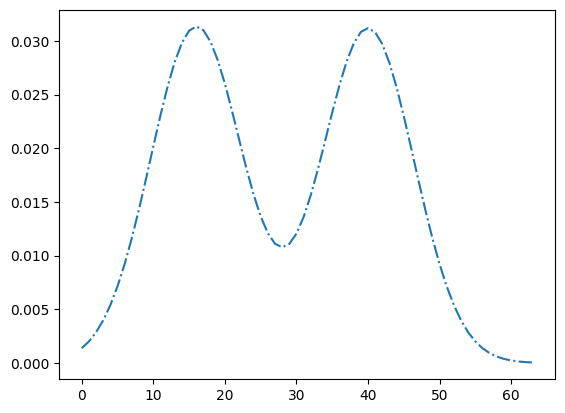

In [2]:
n_wires = 6
x_max = 2**n_wires
x_input = np.arange(x_max)
mus = [(2 / 8) * x_max, (5 / 8) * x_max]
sigmas = [x_max / 10] * 2
data = gaussian_mixture_pdf(x_input, mus, sigmas)

# This is the target distribution that the QCBM will learn
target_probs = torch.tensor(data, dtype=torch.float32)

plt.plot(x_input, target_probs, linestyle="-.", label=r"$\pi(x)$")

Using `torchquantum`, we can create a parameterized quantum circuit which will be used to generate a probability distribution. The gradient-based learning algorithm is used to update the circuit parameters $\theta$ iteratively.

/home/gopald/Documents/tq-env/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


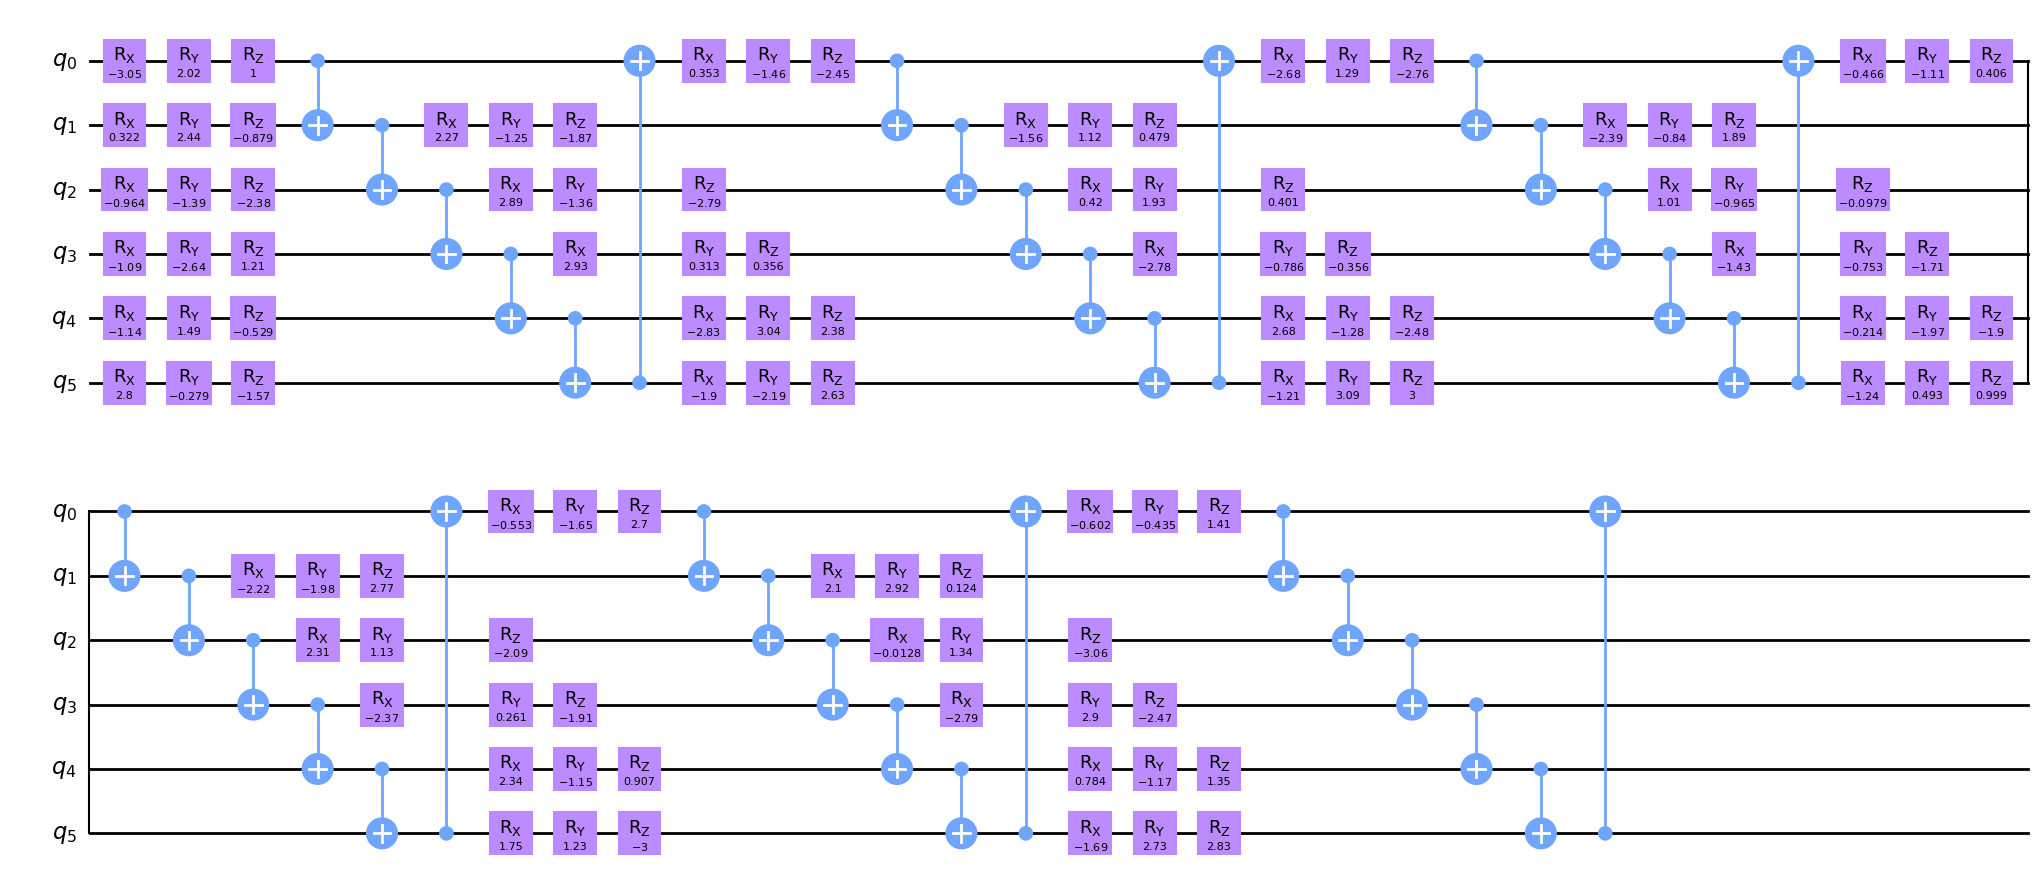

In [3]:
# Ansatz
layers = tq.RXYZCXLayer0(
    {
        "n_blocks": 6,
        "n_wires": n_wires,
        "n_layers_per_block": 1,
    }
)

# We use `tq2qiskit` to visualize the ansatz.
qdev = tq.QuantumDevice(n_wires=n_wires, bsz=1, device="cpu")
tq.plugin.qiskit.tq2qiskit(qdev, layers).draw(output="mpl", fold=30)

We can now simulate the circuit to model the gaussian mixture distribution. The algorithm minimizes the kerneled maximum mean discrepancy (MMD) loss to train the QCBM.

In [4]:
qcbm = QCBM(n_wires, layers)

# To train QCBMs, we use MMDLoss with radial basis function kernel.
bandwidth = torch.tensor([0.25, 60])
space = torch.arange(2**n_wires)
mmd = MMDLoss(bandwidth, space)

# Optimization
optimizer = torch.optim.RMSprop(qcbm.parameters(), lr=0.01)

In [5]:
for i in range(100):
    optimizer.zero_grad(set_to_none=True)
    pred_probs = qcbm()
    loss = mmd(pred_probs, target_probs)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iteration: {i}, Loss: {loss.item()}")

Iteration: 0, Loss: 0.007511706091463566
Iteration: 10, Loss: 0.0008048344170674682
Iteration: 20, Loss: 0.0004957925993949175
Iteration: 30, Loss: 0.0003518108860589564
Iteration: 40, Loss: 0.0002739735064096749
Iteration: 50, Loss: 0.0002034252102021128
Iteration: 60, Loss: 0.00014893575280439109
Iteration: 70, Loss: 0.0001268944761250168
Iteration: 80, Loss: 0.00010558744543232024
Iteration: 90, Loss: 8.735547453397885e-05


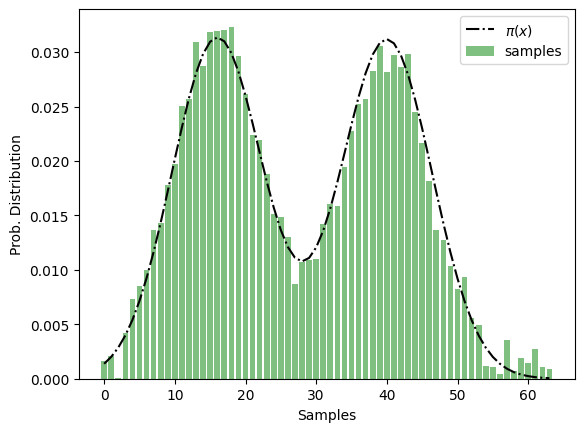

In [6]:
# Visualize the results
with torch.no_grad():
    pred_probs = qcbm()

plt.plot(x_input, target_probs, linestyle="-.", color="black", label=r"$\pi(x)$")
plt.bar(x_input, pred_probs, color="green", alpha=0.5, label="samples")
plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()

## References

1. Liu, Jin-Guo, and Lei Wang. "Differentiable learning of quantum circuit born machines." Physical Review A 98.6 (2018): 062324.